In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
datapath = "../../r01_abcd_dti/" 

In [3]:
abcd = pd.read_parquet(datapath + "abcd_twin_bundles.parquet")

In [25]:
chen = pd.read_parquet(datapath + "abcc_twin_bundle_stats_chen.parquet")
hao = pd.read_parquet(datapath + "abcc_twin_bundle_stats_hao.parquet")

In [26]:
print(len(chen))
print(len(hao))

101336
101548


In [27]:
chen = chen[chen["number_of_tracts"].notna()]
hao = hao[hao["number_of_tracts"].notna()]
print(len(chen))
print(len(hao))

61778
61803


In [44]:
metrics = ['bundle_name',
                 'number_of_tracts',
                 'mean_length_mm',
                 'span_mm',
                 'curl',
                 'elongation',
                 'total_volume_mm3',
                 'first_quarter_volume_mm3',
                 'second_and_third_quarter_volume_mm3',
                 'fourth_quarter_volume_mm3',
                 'total_surface_area_mm2',
                 'total_radius_of_end_regions_mm',
                 'total_area_of_end_regions_mm2',
                 'irregularity',
                 'area_of_end_region_1_mm2',
                 'radius_of_end_region_1_mm',
                 'volume_of_end_branches_1',
                 'area_of_end_region_2_mm2',
                 'radius_of_end_region_2_mm',
                 'volume_of_end_branches_2',
                 'qa','dti_fa',
                 'txx','txy','txz','tyy','tyz','tzz',
                 'rd1','rd2','ha','md','ad','rd',
                 'gfa','iso','rdi',
                 'nrdi02L','nrdi04L','nrdi06L',
                 'subject_id', 'Manufacturer']

In [45]:
chen.rename(columns = {'1st_quarter_volume_mm3' : "first_quarter_volume_mm3",
                      '2nd_and_3rd_quarter_volume_mm3' : "second_and_third_quarter_volume_mm3",
                      '4th_quarter_volume_mm3' : "fourth_quarter_volume_mm3"}, inplace = True)
hao.rename(columns = {'1st_quarter_volume_mm3' : "first_quarter_volume_mm3",
                      '2nd_and_3rd_quarter_volume_mm3' : "second_and_third_quarter_volume_mm3",
                      '4th_quarter_volume_mm3' : "fourth_quarter_volume_mm3"}, inplace = True)

In [46]:
def corr_clustermap(df):
    corr = df.corr(numeric_only=True)
    sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-1, vmax=1,
            cmap = "Spectral")
    plt.show()
    return corr

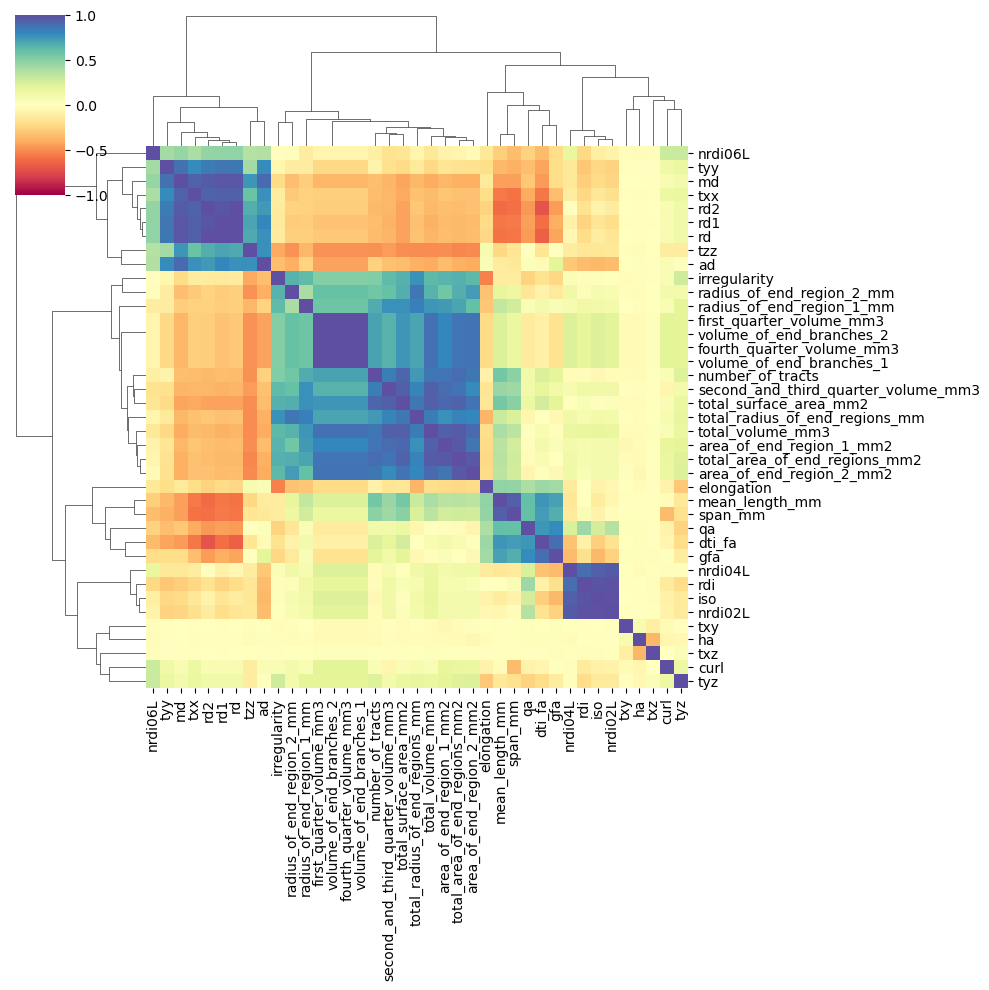

In [49]:
chen_corr = corr_clustermap(chen[metrics])

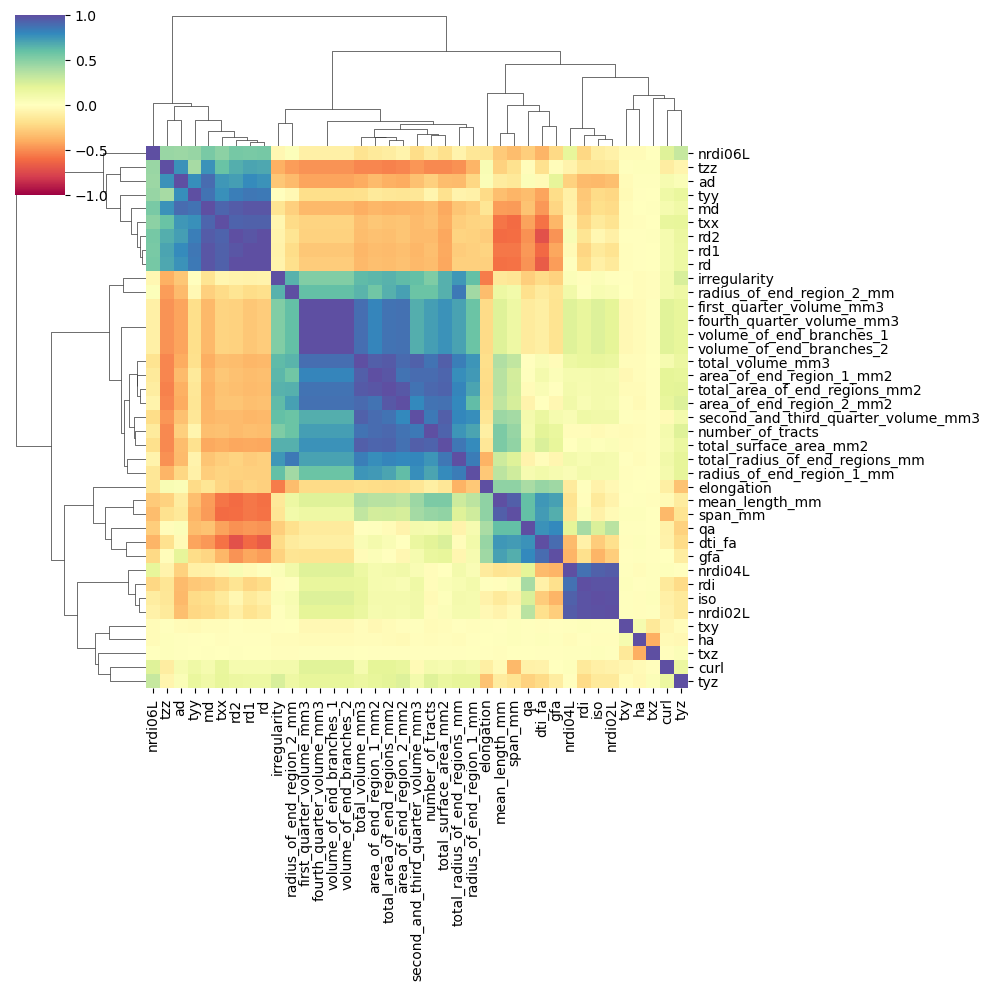

In [50]:
hao_corr = corr_clustermap(hao[metrics])

Correlation between metrics before and after update is mostly consistent

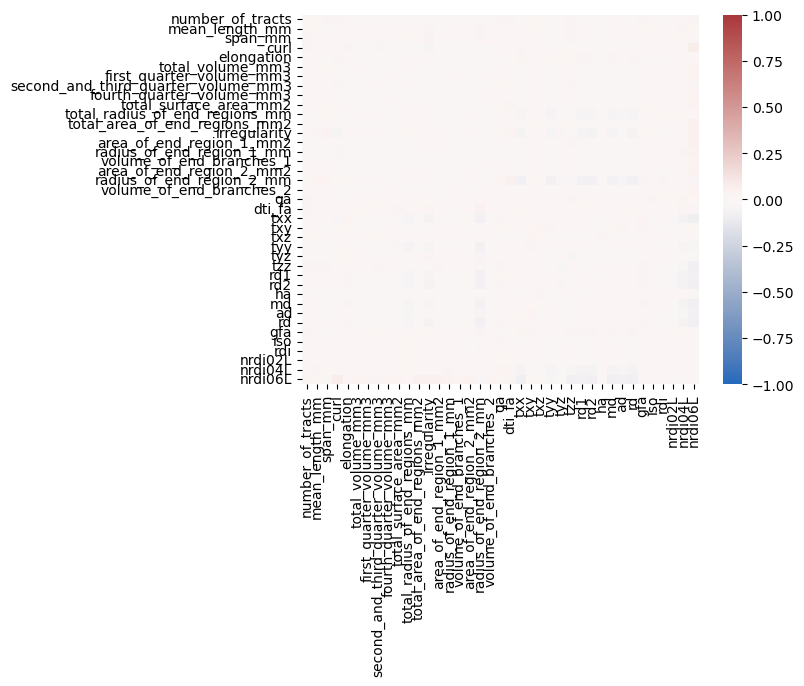

In [53]:
diff = chen_corr - hao_corr
sns.heatmap(diff, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           vmin=-1, vmax=1, cmap="vlag")
plt.show()

number_of_tracts: 

statistic: 0.026606122334508764
P-value: 1.9693307658665775e-19



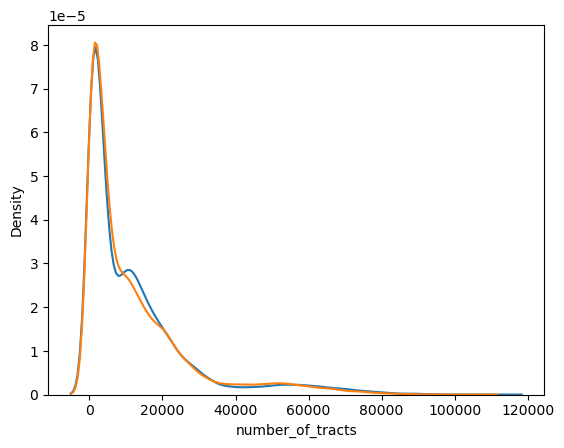

mean_length_mm: 

statistic: 0.04269115262958956
P-value: 2.298113546067874e-49



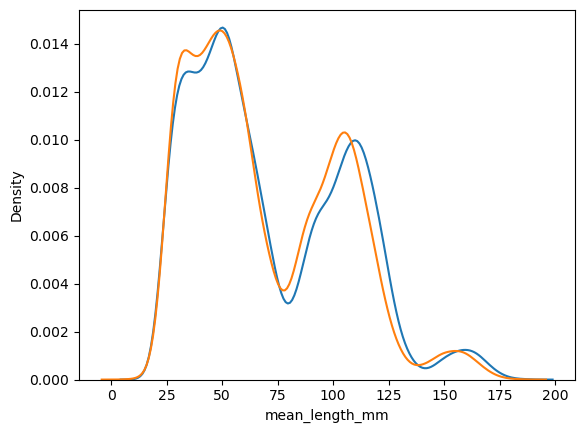

span_mm: 

statistic: 0.036914125847787194
P-value: 5.1601067149913e-37



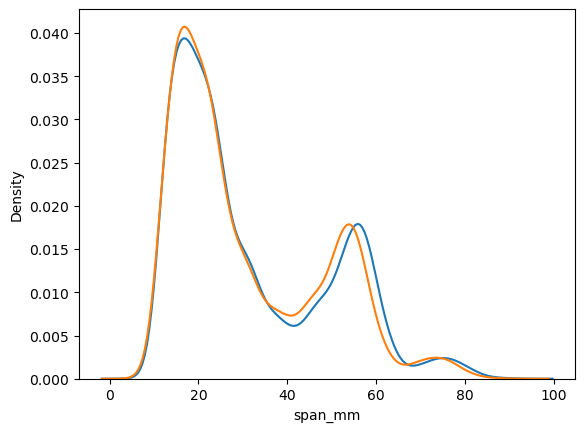

curl: 

statistic: 0.009337503983371742
P-value: 0.009090269523533345



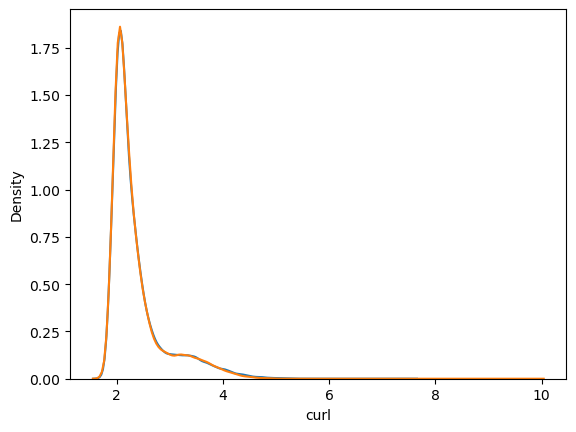

elongation: 

statistic: 0.03796546945464396
P-value: 3.9671932474144594e-39



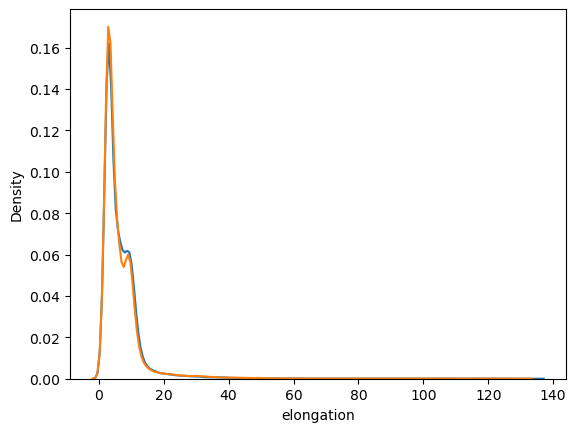

total_volume_mm3: 

statistic: 0.04409760248512262
P-value: 1.2096110122767857e-52



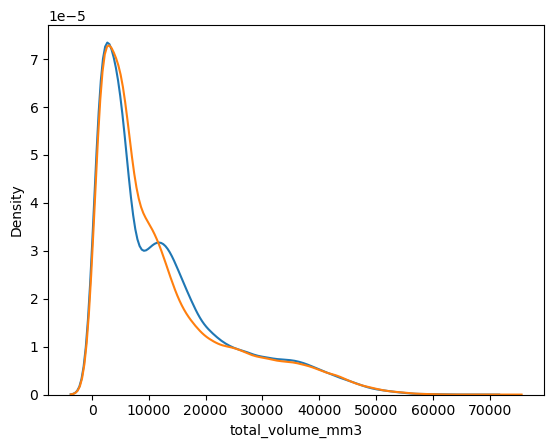

first_quarter_volume_mm3: 

statistic: 0.030271547441094948
P-value: 4.973718643975249e-25



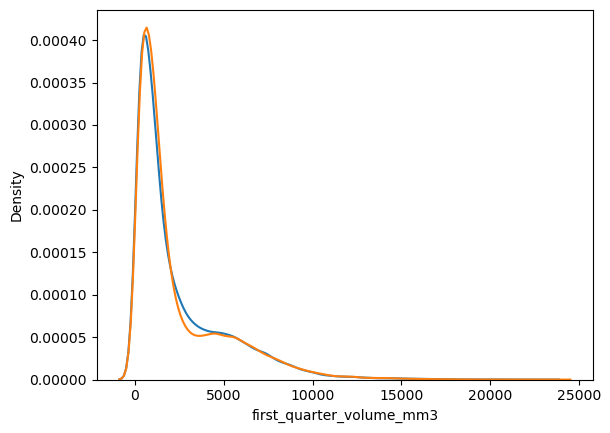

second_and_third_quarter_volume_mm3: 

statistic: 0.037324505634087624
P-value: 7.843080209027661e-38



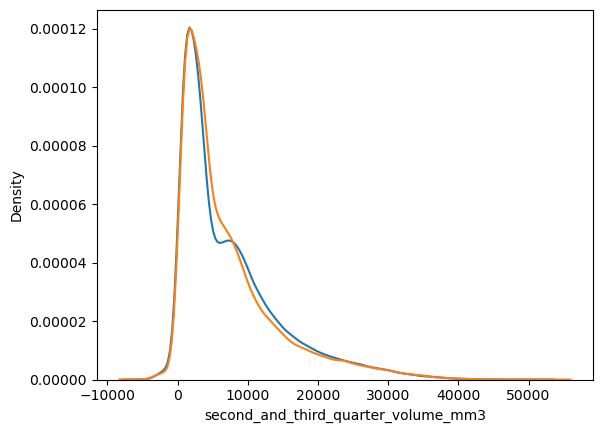

fourth_quarter_volume_mm3: 

statistic: 0.030271547441094948
P-value: 4.973718643975249e-25



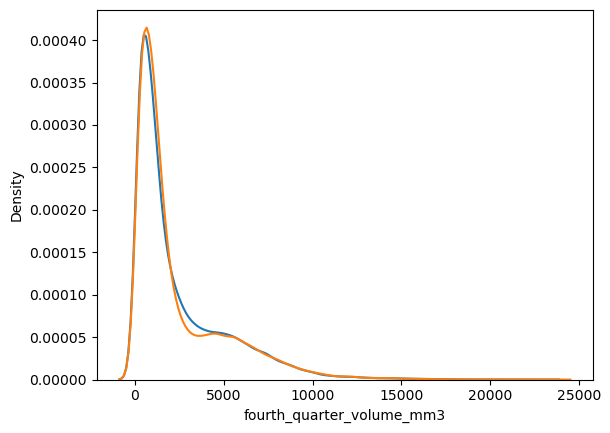

total_surface_area_mm2: 

statistic: 0.042048696168414335
P-value: 6.662845794204668e-48



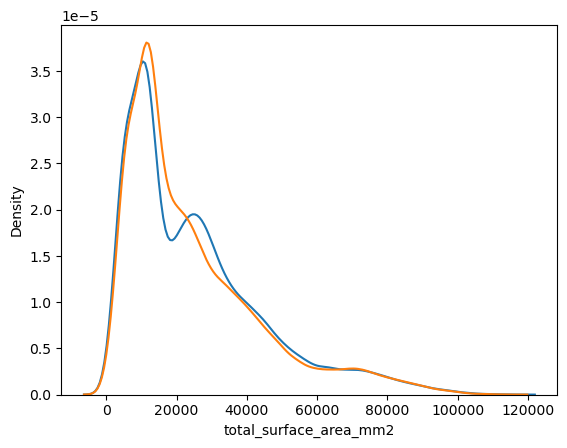

total_radius_of_end_regions_mm: 

statistic: 0.0290314773821021
P-value: 4.690788570309791e-23



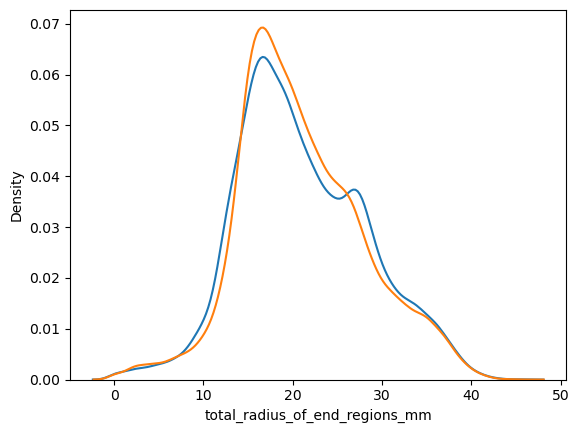

total_area_of_end_regions_mm2: 

statistic: 0.03486703668156388
P-value: 4.5571570584520936e-33



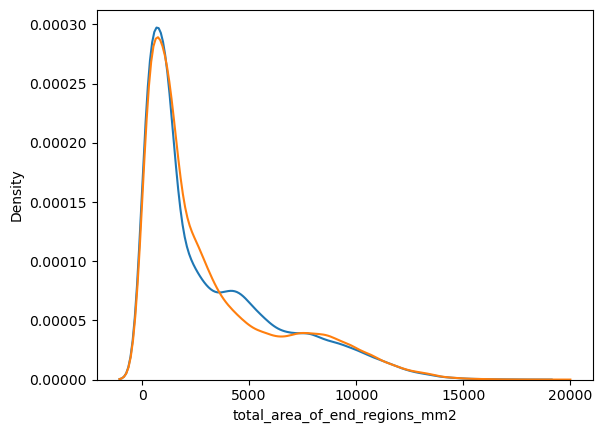

irregularity: 

statistic: 0.03247431072123075
P-value: 9.670658151588128e-29



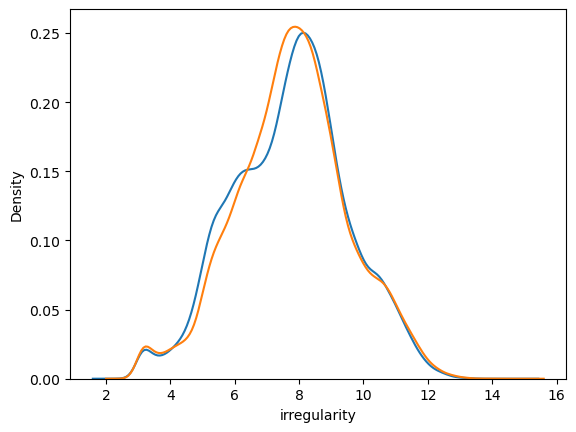

area_of_end_region_1_mm2: 

statistic: 0.03664655816530782
P-value: 1.742730868646792e-36



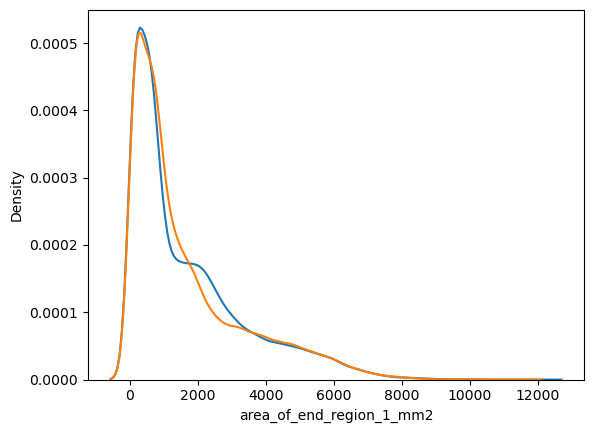

radius_of_end_region_1_mm: 

statistic: 0.03568007349556024
P-value: 1.3134946452594442e-34



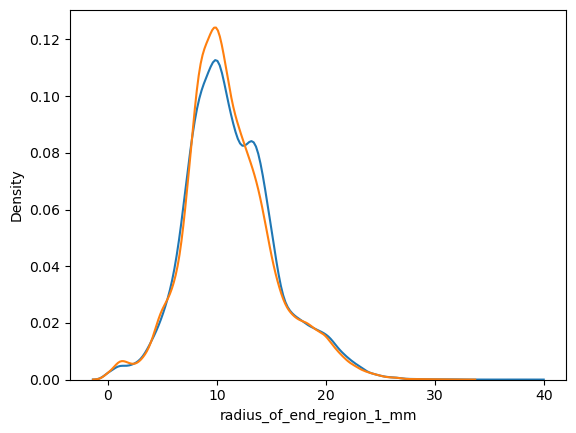

volume_of_end_branches_1: 

statistic: 0.030271547441094948
P-value: 4.973718643975249e-25



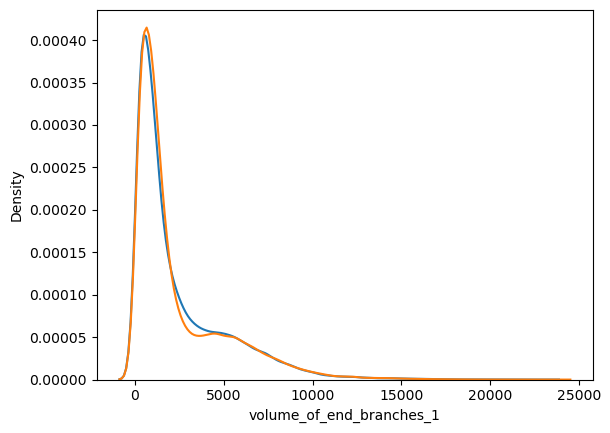

area_of_end_region_2_mm2: 

statistic: 0.03257912059824164
P-value: 6.344142879823166e-29



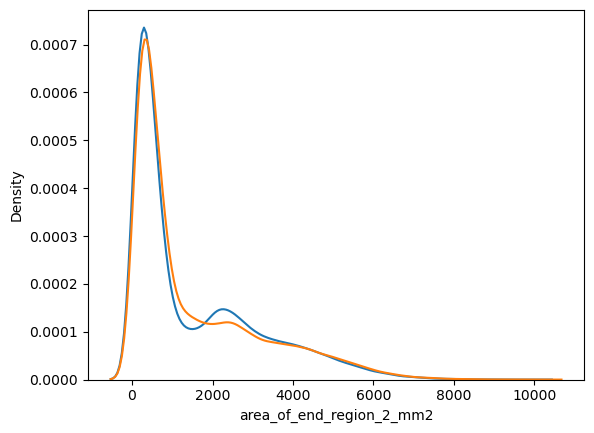

radius_of_end_region_2_mm: 

statistic: 0.04840652201301257
P-value: 2.3713869649801146e-63



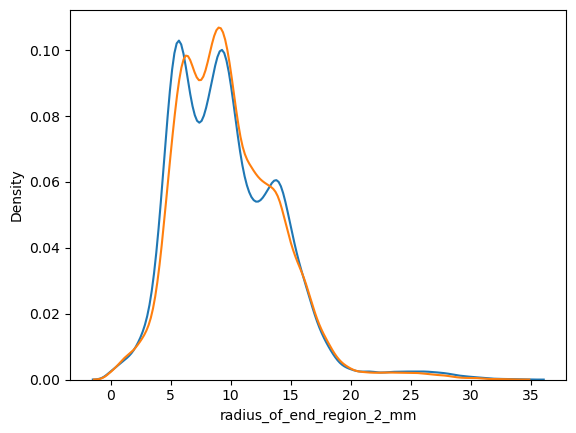

volume_of_end_branches_2: 

statistic: 0.030271547441094948
P-value: 4.973718643975249e-25



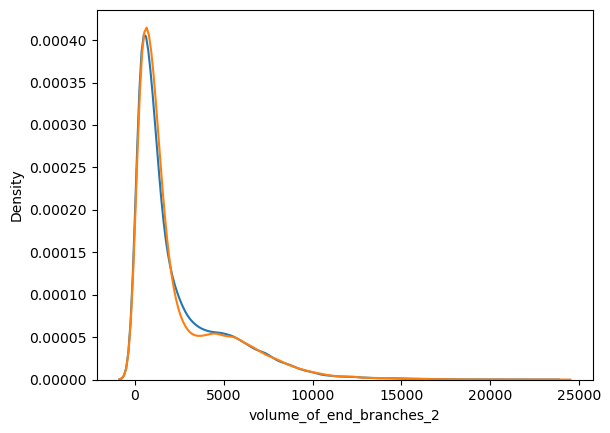

qa: 

statistic: 0.0030038623740468173
P-value: 0.9423792239433768



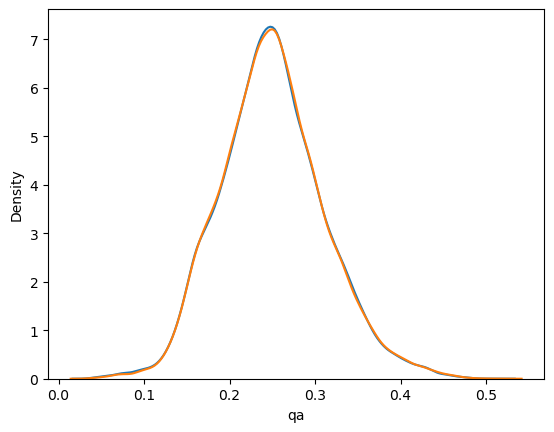

dti_fa: 

statistic: 0.008358070610420765
P-value: 0.026544078903385948



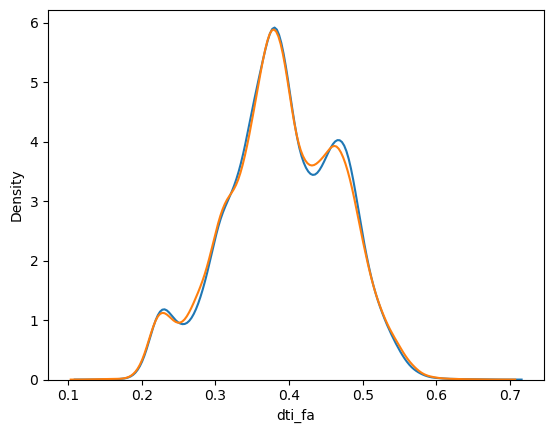

txx: 

statistic: 0.019065387311637094
P-value: 3.471714378715008e-10



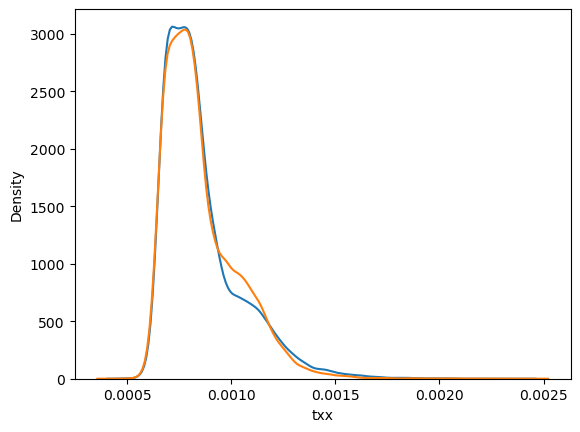

txy: 

statistic: 0.010620716568312483
P-value: 0.0018660214939744861



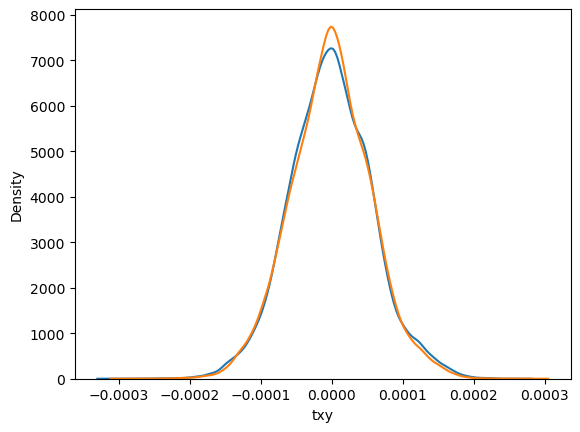

txz: 

statistic: 0.012903334157211233
P-value: 6.748859220900897e-05



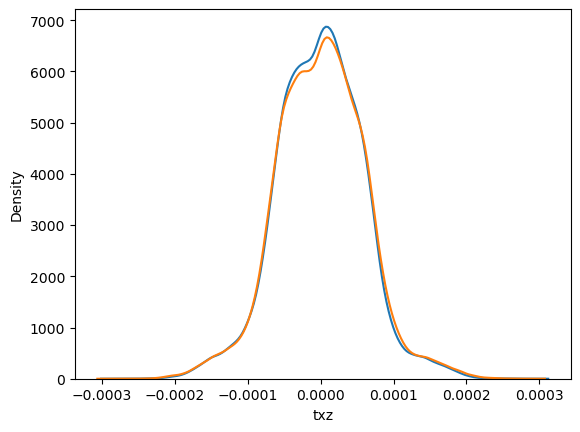

tyy: 

statistic: 0.013251698510437393
P-value: 3.842426376621911e-05



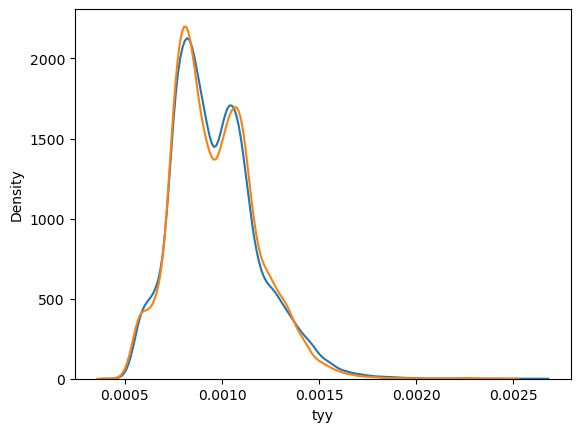

tyz: 

statistic: 0.016464660479834414
P-value: 1.0502538058344396e-07



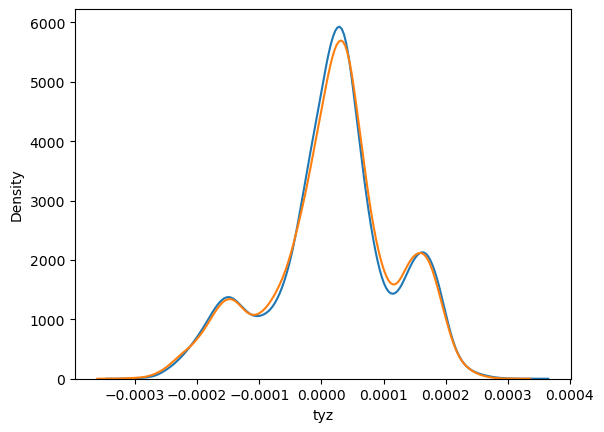

tzz: 

statistic: 0.014143304951281355
P-value: 8.48859947094691e-06



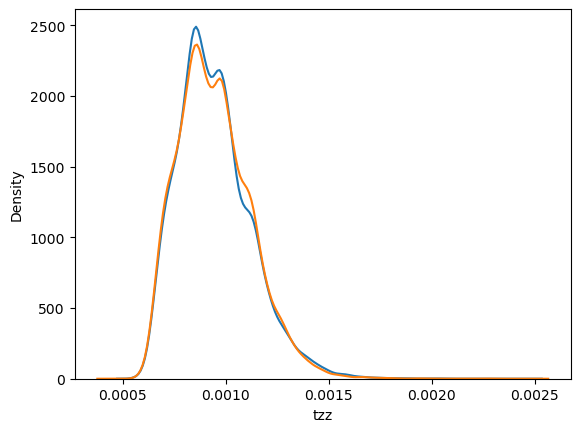

rd1: 

statistic: 0.013940193728471884
P-value: 1.2077479641289353e-05



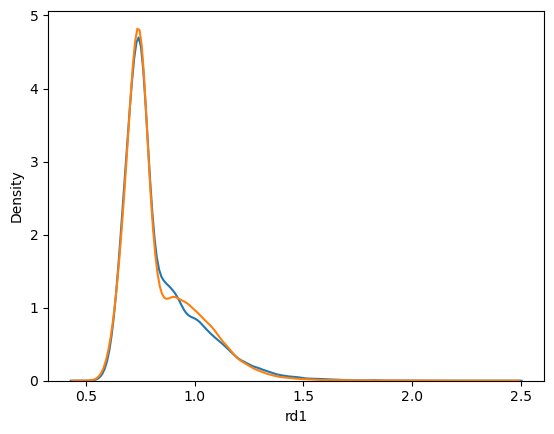

rd2: 

statistic: 0.018978853180739885
P-value: 4.255268744474191e-10



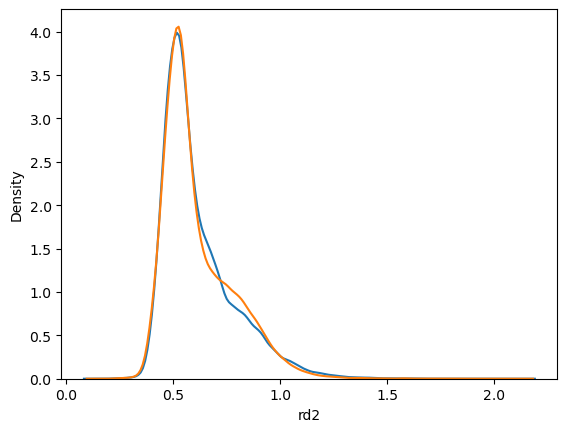

ha: 

statistic: 0.011517856177381325
P-value: 0.0005465754177156419



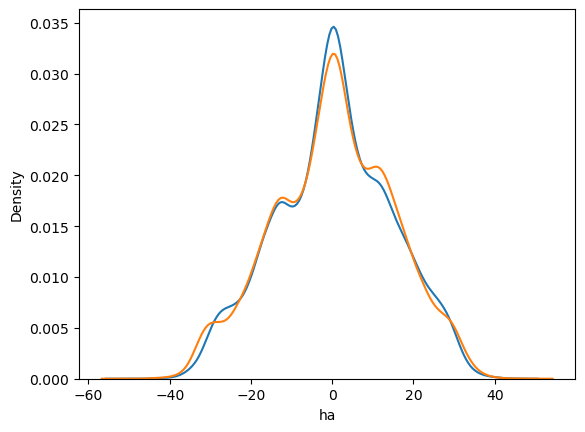

md: 

statistic: 0.017087889665966638
P-value: 2.883378391267422e-08



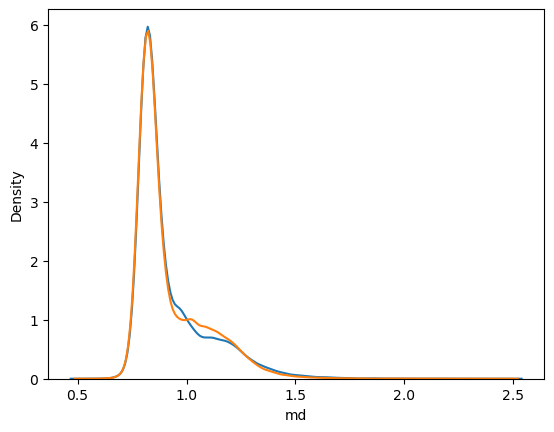

ad: 

statistic: 0.013066069962010762
P-value: 5.197165397510681e-05



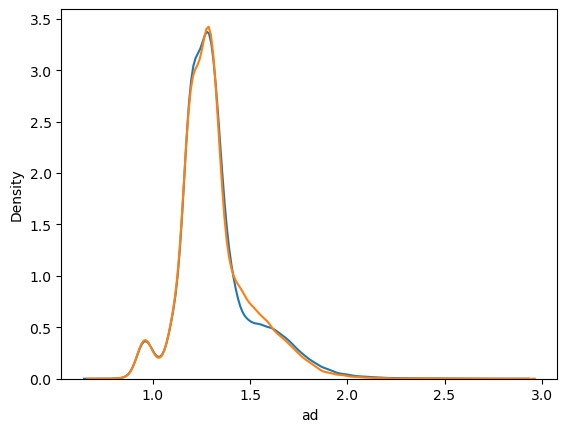

rd: 

statistic: 0.016111503123743764
P-value: 2.138725027047674e-07



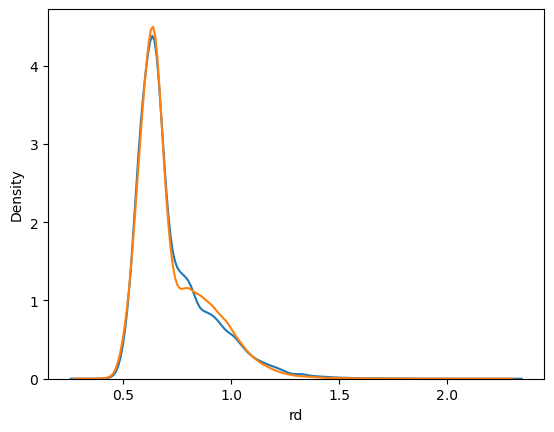

gfa: 

statistic: 0.009241539684816752
P-value: 0.010149646750457856



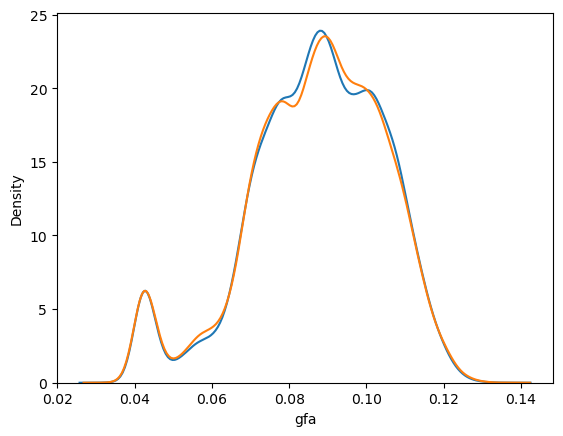

iso: 

statistic: 0.01082843195491201
P-value: 0.0014167477447645906



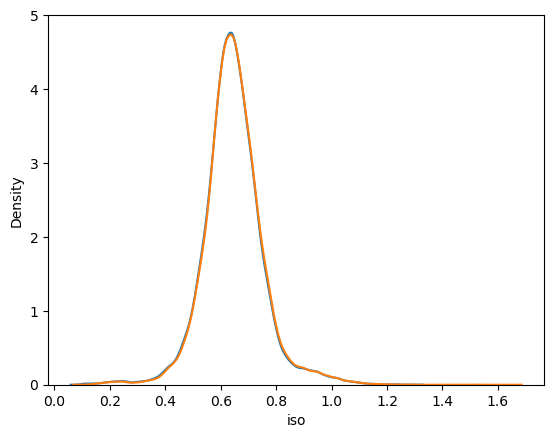

rdi: 

statistic: 0.008599801388332995
P-value: 0.020601205419728773



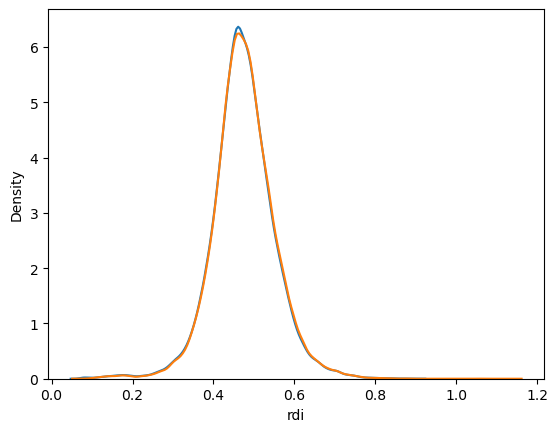

nrdi02L: 

statistic: 0.009840783951259202
P-value: 0.005005057262217553



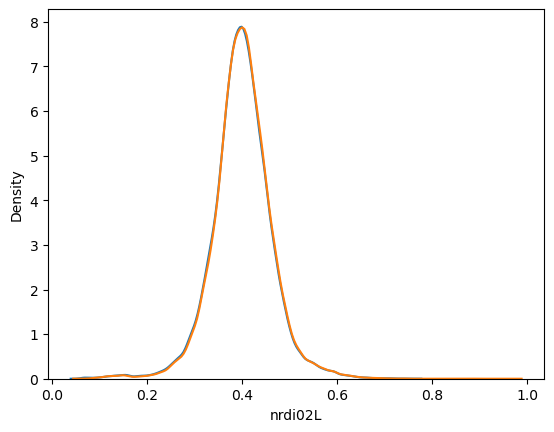

nrdi04L: 

statistic: 0.01231989160928365
P-value: 0.00016762439785983937



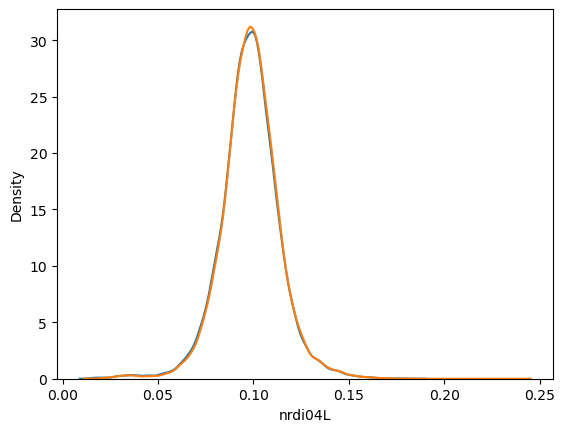

nrdi06L: 

statistic: 0.0228392581676804
P-value: 1.9718670808720942e-14



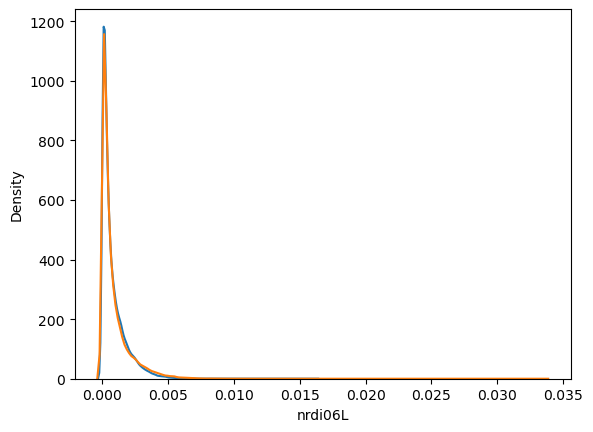

In [61]:
for col in chen[metrics[1:-2]]:
    stat, p_value =  stats.ks_2samp(list(chen[col]), list(hao[col]))
    print(col + ": \n")
    print(f"statistic: {stat}")
    print(f"P-value: {p_value}" + "\n")
    fig, ax = plt.subplots()
    sns.kdeplot(data=chen, x=col, ax=ax)
    sns.kdeplot(data=hao, x=col, ax=ax)
    plt.show()

In [62]:
def anova(df):
    for col in df.columns[2:-2]:
        model = ols(col + ' ~ C(Manufacturer)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        if anova_table["PR(>F)"][0] < 0.05:     
            print("\n" + col)
            print(anova_table)

In [64]:
anova(chen[metrics])


mean_length_mm
                       sum_sq       df          F        PR(>F)
C(Manufacturer)  1.506313e+05      1.0  125.01415  5.388199e-29
Residual         7.443477e+07  61776.0        NaN           NaN

span_mm
                       sum_sq       df          F        PR(>F)
C(Manufacturer)  1.709198e+04      1.0  56.079784  7.051150e-14
Residual         1.882807e+07  61776.0        NaN           NaN

curl
                       sum_sq       df          F        PR(>F)
C(Manufacturer)     11.795345      1.0  42.521833  7.043469e-11
Residual         17136.355584  61776.0        NaN           NaN

elongation
                       sum_sq       df          F    PR(>F)
C(Manufacturer)  1.391877e+03      1.0  21.945335  0.000003
Residual         3.918128e+06  61776.0        NaN       NaN

total_volume_mm3
                       sum_sq       df          F        PR(>F)
C(Manufacturer)  8.642102e+09      1.0  66.046054  4.485864e-16
Residual         8.083367e+12  61776.0        NaN      

In [65]:
anova(hao[metrics])


mean_length_mm
                       sum_sq       df           F        PR(>F)
C(Manufacturer)  1.304041e+05      1.0  116.634998  3.649118e-27
Residual         6.909681e+07  61801.0         NaN           NaN

span_mm
                       sum_sq       df          F        PR(>F)
C(Manufacturer)  1.405095e+04      1.0  49.553494  1.950392e-12
Residual         1.752375e+07  61801.0        NaN           NaN

curl
                      sum_sq       df          F        PR(>F)
C(Manufacturer)     15.43951      1.0  60.707894  6.723062e-15
Residual         15717.51348  61801.0        NaN           NaN

elongation
                       sum_sq       df          F        PR(>F)
C(Manufacturer)  2.518058e+03      1.0  38.924578  4.433445e-10
Residual         3.997950e+06  61801.0        NaN           NaN

total_volume_mm3
                       sum_sq       df          F        PR(>F)
C(Manufacturer)  1.009955e+10      1.0  78.279411  9.175011e-19
Residual         7.973519e+12  61801.0     